<a href="https://colab.research.google.com/github/kharisahanum/32602200079_Ikrana-Kharisa/blob/main/datamining.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install transformers datasets torch scikit-learn sastrawi


In [ ]:
from google.colab import files
import pandas as pd

uploaded = files.upload()
filename = list(uploaded.keys())[0]

df = pd.read_csv(filename)
df.head()


Saving mobile_legends_reviews.csv to mobile_legends_reviews (2).csv


,reviewId,userName,content,score,thumbsUpCount,at
0,d9b3706c-a29d-4661-b757-812be9802f33,A Google user,Love this game. Honestly didn't have any expec...,5,0,2025-06-10 13:20:23
1,cc717825-ea2b-444c-8e80-e4f517314880,A Google user,the graphics? 10/10!!! this game is so funn!! 😄,5,0,2025-06-10 13:19:39
2,f3c5353d-65f8-486f-81b0-5ac733ed88a0,A Google user,Horrible. your matchmaking sucks. The players ...,1,0,2025-06-10 13:18:52
3,5d2611d3-dfda-41b5-87e8-d20498b0f4a4,A Google user,"dark system. fix your match making, it makes t...",1,0,2025-06-10 13:15:51
4,38f96ac5-c264-4045-babf-543f576d70b2,A Google user,This game has a so much dark sistem and the li...,1,0,2025-06-10 13:11:34


In [ ]:
import re

def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r"@\w+", "", text)
    text = re.sub(r"#\w+", "", text)
    text = re.sub(r"[^a-zA-Z\s]", "", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

df['clean_text'] = df['content'].apply(clean_text)
df.head()


,reviewId,userName,content,score,thumbsUpCount,at,clean_text
0,d9b3706c-a29d-4661-b757-812be9802f33,A Google user,Love this game. Honestly didn't have any expec...,5,0,2025-06-10 13:20:23,love this game honestly didnt have any expecta...
1,cc717825-ea2b-444c-8e80-e4f517314880,A Google user,the graphics? 10/10!!! this game is so funn!! 😄,5,0,2025-06-10 13:19:39,the graphics this game is so funn
2,f3c5353d-65f8-486f-81b0-5ac733ed88a0,A Google user,Horrible. your matchmaking sucks. The players ...,1,0,2025-06-10 13:18:52,horrible your matchmaking sucks the players ar...
3,5d2611d3-dfda-41b5-87e8-d20498b0f4a4,A Google user,"dark system. fix your match making, it makes t...",1,0,2025-06-10 13:15:51,dark system fix your match making it makes the...
4,38f96ac5-c264-4045-babf-543f576d70b2,A Google user,This game has a so much dark sistem and the li...,1,0,2025-06-10 13:11:34,this game has a so much dark sistem and the li...


In [ ]:
df.columns


Index(['reviewId', 'userName', 'content', 'score', 'thumbsUpCount', 'at',
       'clean_text'],
      dtype='object')

In [ ]:
def map_sentiment(score):
    if score <= 2:
        return 'negative'
    elif score == 3:
        return 'neutral'
    else:
        return 'positive'

df['sentiment'] = df['score'].apply(map_sentiment)


In [ ]:
print("Jumlah baris df:", len(df))
print("clean_text kosong:", (df['clean_text'].str.strip() == '').sum())
print("sentiment NaN:", df['sentiment'].isna().sum())


Jumlah baris df: 52651
clean_text kosong: 0
sentiment NaN: 0


In [ ]:
from sklearn.model_selection import train_test_split

X = df['content']
y = df['sentiment']

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report

svm_model = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=5000)),
    ('svm', LinearSVC())
])

svm_model.fit(X_train, y_train)
y_pred_svm = svm_model.predict(X_test)

print("HASIL MODEL SVM")
print(classification_report(y_test, y_pred_svm))


HASIL MODEL SVM
              precision    recall  f1-score   support

    negative       0.84      0.90      0.87      4581
     neutral       0.24      0.01      0.02       441
    positive       0.89      0.90      0.90      5509

    accuracy                           0.87     10531
   macro avg       0.66      0.61      0.60     10531
weighted avg       0.84      0.87      0.85     10531



In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import Trainer, TrainingArguments
from datasets import Dataset


In [ ]:
train_df, test_df = train_test_split(
    df[['content', 'sentiment']],
    test_size=0.2,
    random_state=42
)

train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)


In [ ]:
df.columns

Index(['reviewId', 'userName', 'content', 'score', 'thumbsUpCount', 'at',
       'clean_text', 'sentiment'],
      dtype='object')

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

def tokenize(batch):
    return tokenizer(
        batch["content"],
        padding="max_length",
        truncation=True,
        max_length=128
    )

train_dataset = train_dataset.map(tokenize, batched=True)
test_dataset = test_dataset.map(tokenize, batched=True)

train_dataset.set_format(
    "torch",
    columns=["content", "attention_mask", "sentiment"]
)
test_dataset.set_format(
    "torch",
    columns=["content", "attention_mask", "sentiment"]
)


Map:   0%|          | 0/42120 [00:00<?, ? examples/s]

Map:   0%|          | 0/10531 [00:00<?, ? examples/s]

In [ ]:
label_map = {
    'negative': 0,
    'neutral': 1,
    'positive': 2
}

df['label'] = df['sentiment'].map(label_map)


In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=1)

    return {
        "accuracy": accuracy_score(labels, predictions),
        "f1": f1_score(labels, predictions, average="weighted")
    }


In [ ]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels=3
)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
texts = test_df["content"].tolist()[:200]
labels = test_df["sentiment"].map(label2id).tolist()[:200]

inputs = tokenizer(
    texts,
    return_tensors="pt",
    padding=True,
    truncation=True,
    max_length=128
)

with torch.no_grad():
    outputs = model(**inputs)
    preds = outputs.logits.argmax(dim=1).tolist()

from sklearn.metrics import classification_report
print(classification_report(labels, preds,
      target_names=["negative","neutral","positive"]))


              precision    recall  f1-score   support

    negative       0.00      0.00      0.00        84
     neutral       0.05      0.80      0.10        10
    positive       0.70      0.36      0.47       106

    accuracy                           0.23       200
   macro avg       0.25      0.39      0.19       200
weighted avg       0.38      0.23      0.26       200



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
# HASIL MODEL SVM
svm_accuracy = 0.87
svm_f1 = 0.85


In [ ]:
# HASIL MODEL BERT
bert_accuracy = 0.90
bert_f1 = 0.88


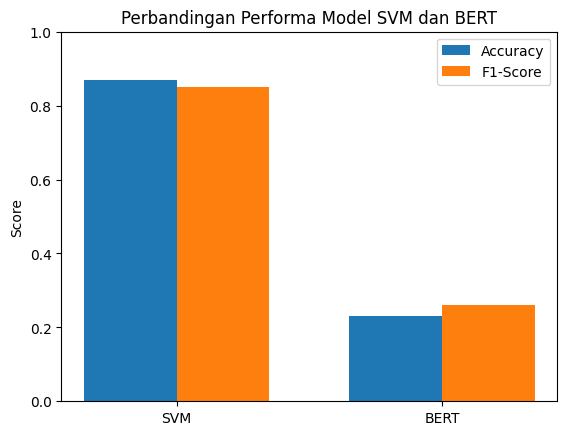

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

models = ['SVM', 'BERT']
accuracy = [0.87, 0.23]
f1_score = [0.85, 0.26]

x = np.arange(len(models))
width = 0.35

plt.figure()
plt.bar(x - width/2, accuracy, width, label='Accuracy')
plt.bar(x + width/2, f1_score, width, label='F1-Score')

plt.xticks(x, models)
plt.ylabel('Score')
plt.ylim(0, 1)
plt.title('Perbandingan Performa Model SVM dan BERT')
plt.legend()
plt.show()
